# Preliminary Time Series Analysis

The purpose of this notebook is to analyze the time series we want to model to confirm whether or not the chosen model (e.g., ARIMA) is appropriate. A lot of this code was inspired by posts from https://machinelearningmastery.com.

In [23]:
%load_ext autoreload
%autoreload 2

# Import local packages
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import market_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we need to load our time series data.

In [11]:
# Restrict time series' else fitting our model will take what feels like forever
data = market_data.load_coingecko_market_data(['btc', 'eth'], series_name='Close Price', rel_path='../data')

Second, we need to check if the time series data is stationary.

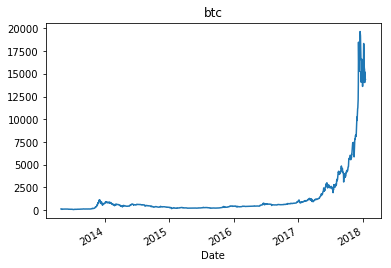

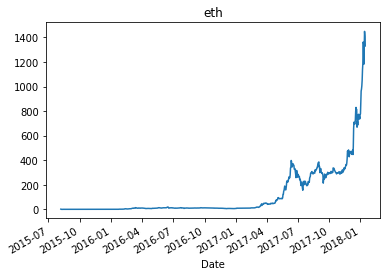

In [12]:
for ticker, ticker_data in data.items():
    ticker_data.plot()
    plt.title(ticker)
    plt.show()

Clearly there are some serious trends in our time series', therefore they are non-stationary. Let's try to change that by computing the first difference per time series.

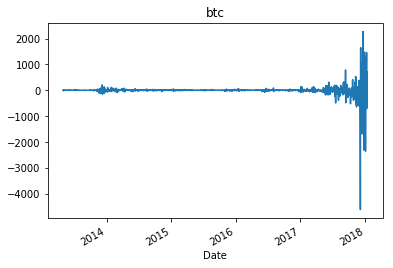

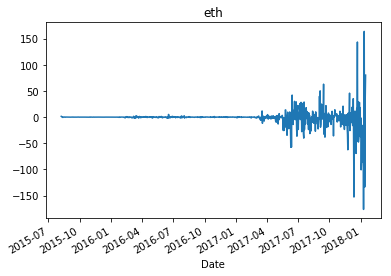

In [13]:
diff_data = {}
for ticker, ticker_data in data.items():
    diff_data[ticker] = ticker_data.shift(1) - ticker_data
    diff_data[ticker].plot()
    plt.title(ticker)
    plt.show()

Alright, it looks like taking the first difference gives our time series' stationarity. Let's check if the original time series' exhibit autocorrelation.

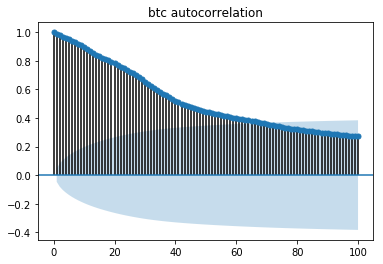

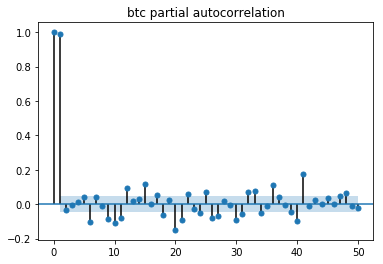

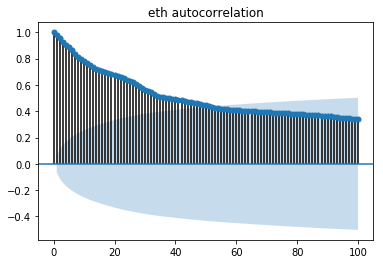

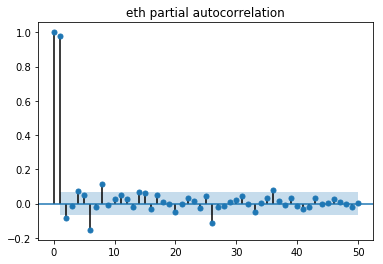

In [22]:
for ticker, ticker_data in data.items():
    plot_acf(ticker_data, lags=100, title='%s autocorrelation' % (ticker))
    plot_pacf(ticker_data, lags=50, title='%s partial autocorrelation' % (ticker))

Alright, looks like we have significant autocorrelation around 40 lags for each time series. This is based on an assumption that lags with over 50% autocorrelation are significant.

Now that we know our autocorrelation and difference factors (40, 1), let's try to fit an ARIMA model to our original time series' data.

In [ ]:
model = ARIMA(data['eth'], order=(40, 1, 0))
fit_model = model.fit(disp=0)
print(fit_model.summary())